<a href="https://colab.research.google.com/github/tnguyen-syd/UTS_microcredentials_machine_learning/blob/main/ThanhN_ML_Implementation_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UTS Micro-credentials
## Machine Learning Foundations
## Assignment: Implementation of supervised models to find potential customers for a marketing company based on US Census data

## Description

In this project, I will attempt to apply supervised learning techniques on a sample US census  data to help a made-up marketing company to identify people who are most likely to be interested in the products this company is selling based on predicting their income.

In doing this, I will attempt the following steps:

1. Step 1: Explore the data to learn how the census data can be used in the models. 

2. Step 2: Perform data transformations to convert the raw data into a workable format.

3. Step 3: Evaluate a number of supervised learners of my choice and find the most suitable model. 

4. Step 4: Optimize the selected model and document my findings.

5. Step 5: Explore the chosen model and its predictions to see how well it's performing against the data given.


The raw sample data for this project is obtained from this [Online Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). 


----
## Step 1: Exploring the Data
Import the data and study the features in the dataset. I am particularly interested in the population where an individual makes more than $50,000 annually - with the assumption that those with this level of income would be the target customer group for this marketing company.



In [ ]:
# Import software and Python libraries needed to run the project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display 

# Import data_viz.py that has the code to display visualisations
from google.colab import files
src = list(files.upload().values())[0]
open('data_viz.py','wb').write(src)
import data_viz as vs

# Nice display for notebooks
%matplotlib inline

Saving data_viz.py to data_viz (3).py


In [ ]:
# Load US census dataset
uploaded = files.upload()
data = pd.read_csv("us_census_1994.csv")

# Display the first record
display(data.head(n=5))

Saving us_census_1994.csv to us_census_1994.csv


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Study the data and its features


In [ ]:
# Count number of records
n_records = data['income'].count()

# Number of records where income is more than $50,000
n_greater_50k = len(data[data['income'].str.contains('>50K')])

# Number of records where income is at most $50,000
n_at_most_50k = len(data[data['income'].str.contains('<=50K')])

# Percentage of people with income more than $50,000
greater_percent = len(data[data['income'].str.contains('>50K')])/data['income'].count()*100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


**Observations of the data features in the dataset**

* **age**: continuous values
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool
* **education-num**: continuous values
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other
* **sex**: Female, Male
* **capital-gain**: continuous values
* **capital-loss**: continuous values
* **hours-per-week**: continuous values
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands

----
## Step 2: Prepare the Data for Learning Models
Data needs to be cleaned, formatted, and restructured so that it is workable to train, test and evaluate the learning models later on.

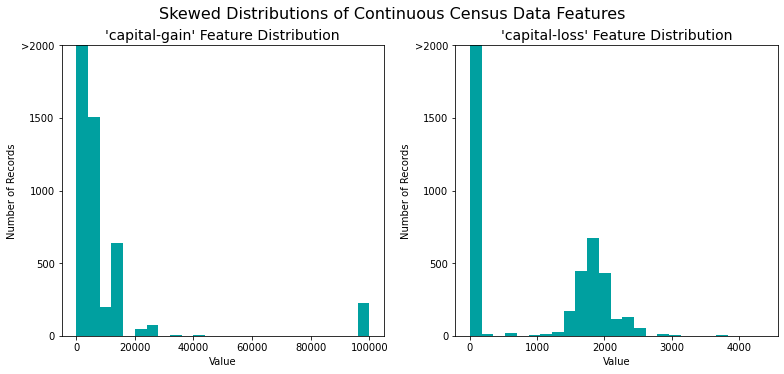

In [ ]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualise continuous features to observe outliners that might skew the models
vs.distribution(data)

From the above graphs, we can see that `'capital-gain'` and `'capital-loss'` have outliners that might negatively affect the models if left untreated. As such, in the code below I will attempt to use a logarithmic transformation to reduce the range of values caused by outliers. 

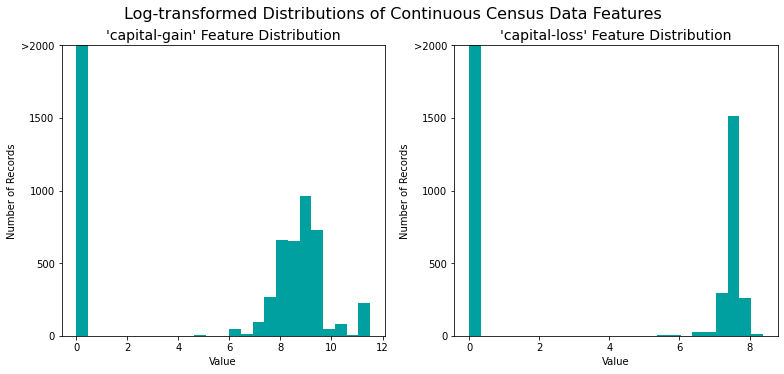

In [ ]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualise the new log distributions
vs.distribution(features_log_transformed, transformed = True)

In [ ]:
### Display the transformed data
display(features_log_transformed.head(n=5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,7.684784,0.0,40.0,United-States
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,13.0,United-States
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,40.0,United-States
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,40.0,United-States
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,40.0,Cuba


### Normalise Numerical Features
Next, I will attempt to use scaling to normalise numerical features. This is to ensure that each feature is treated equally when applying the learning models.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show sample records to see how scaling has been applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Convert non-numeric features

To optimise the performance of the models, next I will attempt to convert non-numeric features to numeric by using **one-hot encoding** scheme. 

In [ ]:
# Use One-hot to encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)
#display(features_final)

# Encode the 'income_raw' data to numerical values
income=pd.get_dummies(income_raw)['>50K']
#display(income)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

print(encoded)
display(features_final.head(n = 5))

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_level_ 10th,education_level_ 11th,education_level_ 12th,education_level_ 1st-4th,education_level_ 5th-6th,education_level_ 7th-8th,education_level_ 9th,education_level_ Assoc-acdm,education_level_ Assoc-voc,education_level_ Bachelors,education_level_ Doctorate,education_level_ HS-grad,education_level_ Masters,education_level_ Preschool,education_level_ Prof-school,education_level_ Some-college,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,...,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.301370,0.800000,0.667492,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.452055,0.800000,0.000000,0.0,0.122449,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.287671,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0.493151,0.400000,0.000000,0.0,0.397959,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.150685,0.800000,0.000000,0.0,0.397959,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Shuffle and split the data
Now that all data features have been  treated and normalised, I will split the data into training and test sets. 80% of the data will be used for training and 20% for testing.


In [ ]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


In [ ]:
#from sklearn.ensemble import RandomForestClassifier
#clf_rf = RandomForestClassifier()
#clf_rf.fit(X_train[:300], y_train[:300])

----
## Step 3: Evaluate a number of supervised learners of my choice and find the most suitable model
In this section, I will investigate a number of algorithms and determine which is best at data modelling. 

With the assumption that the individuals that make more than \\$50,000 are the  target customers for the marketing company, the task here is finding the best model to predict who makes more than \\$50,000 accurately. 

To evaluate the performance of the models, I will use **Accuracy** and **F-beta score** as the primary metrics as **F-beta score** which considers both **precision** and **recall**:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

Note that when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).


### For Consideration: 
* When we have a model that always predicts '1' (i.e. the individual makes more than \$50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 

* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [ ]:
# CALCULATE THE ACCURACY SCORE AND F-SCORE OF THE NAIVE PREDICTOR FOR COMPARISON 
# AGAINST OTHER LEANRING MODELS LATER ON

# Total number of records: 45222
# Individuals making more than $50,000: 11208
# Individuals making at most $50,000: 34014

# When we have a model that always predicts '1' (i.e. the individual makes more than 50k) 
# TP = 11208
# FP = 34014
# TN = 0
# FN = 0

# Calculate accuracy, precision and recall
accuracy = 11208/45222
recall = 11208/(11208+0) # =TP/(TP+FN)
precision = 11208/(11208+34014) # =TP/(TP+FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta=0.5
fscore = (1+beta*beta)*(precision*recall)/(beta*beta*precision+recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Select and Apply Learning Models
From the supervised learning models available in [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html), I have chosen the following algorithms for this problem:
- Decision Trees
- AdaBoost (Ensemble Method) 
- Support Vector Machines (SVM)

My rationale for selecting the above 3 models are based on the following factors:
- The input data set has 13 features in total, 5 of them are numerical and 8 are text based categorical features
- The ask is to predict and classify if an input record resulting in an individual making more and less than 50k per year.
- Data is non linear
- Data set is sizable (close to 50,000 records)

**More information on these 3 models based on my research:**

**1.Random Forest**

Source: https://towardsdatascience.com/why-random-forest-is-my-favorite-machine-learning-model-b97651fa3706

- **Example applications**: Looking at different weather & traffic factors to predict if turn out of sport events

- **What are the strengths of the model?**
Random forest improves on bagging because it decorrelates decision trees with the introduction of splitting on a random subset of features. Whether you have a regression or classification task, random forest is an applicable model for your needs. It can handle binary features, categorical features, and numerical features. There is very little pre-processing that needs to be done. The data does not need to be rescaled or transformed.They are parallelizable, meaning that we can split the process to multiple machines to run. Random forests is great with high dimensional data since we are working with subsets of data. It provide quick prediction and training speed.

- **What are the weaknesses of the model?**
Model interpretability: Random forest models are not all that interpretable; they are like black boxes. For very large data sets, the size of the trees can take up a lot of memory. It can tend to overfit, so you should tune the hyperparameters.

**2.AdaBoost**

Source: http://www.nickgillian.com/wiki/pmwiki.php/GRT/AdaBoost

- **Example applications**: predicting customer churn and classifying the types of topics customers are talking/calling about

- **What are the strengths of the model?**
AdaBoost is a great classification algorithm. Comapred to SVM, it can achieve similar classification results with much less tweaking of parameters or settings. The user only needs to choose: (1) which weak classifier might work best to solve their given classification problem; (2) the number of boosting rounds that should be used during the training phase. 

- **What are the weaknesses of the model?**
AdaBoost can be sensitive to noisy data and outliers. In some problems, however, it can be less susceptible to the overfitting problem than most learning algorithms. 

**3.Support Vector Machines (SVM)**

Source: https://data-flair.training/blogs/applications-of-svm/

- **Example applications**: Face detection, classification of images and bioinformatics.

- **What are the strengths of the model?**
It is really effective in the higher dimension and/or when the number of features are more than training examples. It is a great algorithm when classes are separable. The hyperplane is affected by only the support vectors thus outliers have less impact. SVM is suited for extreme case binary classification.

- **What are the weaknesses of the model?**
For larger dataset, it requires a large amount of time to process. It does not perform well in case of overlapped classes. Selecting, appropriately hyperparameters of the SVM that will allow for sufficient generalization performance. Selecting the appropriate kernel function can be tricky.


### Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model, I will create a training and predicting pipeline that will train models using various sizes of training data and perform predictions on the testing data. 


In [ ]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score,fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm 
       - sample_size: the size of samples from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the model to the training data 
    start = time() # Get start time
    #print(y_train.shape)
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size]) 
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
          
    # Get the predictions on the test set(X_test),
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the the training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,average='binary',beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,average='binary',beta=0.5)
       
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Evalutating the initial models

RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.


/content/data_viz.py:116: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


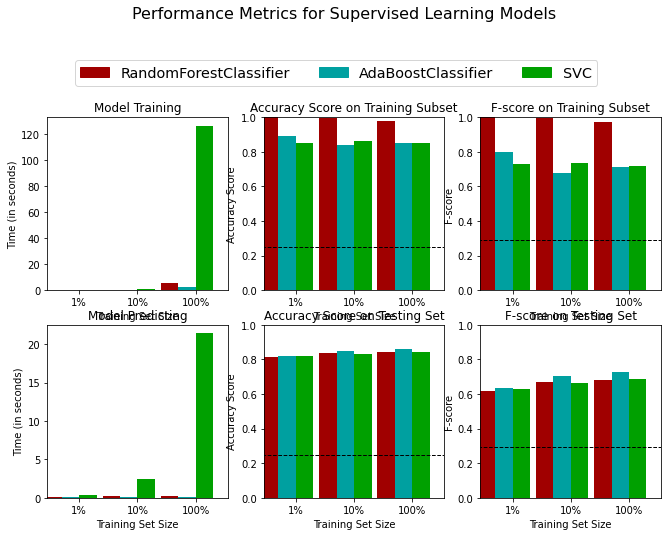

In [ ]:
# Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

# Initialize the three models
clf_A = RandomForestClassifier(random_state = 42)
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = SVC(random_state = 42)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(0.1*len(y_train))
samples_1 = int(0.01*len(y_train))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
        
        # Below is for testing
        #clf_A.fit(X_train[:samples], y_train[:samples])
        #predictions_test = clf_A.predict(X_test)
        #print(accuracy_score(y_test,predictions_test))
        #print(fbeta_score(y_test,predictions_test,average='samples',beta=0.5))        

# Visualise the returned metrics for the chosen models
vs.evaluate(results, accuracy, fscore)

### Choosing the Best Model

Out of the 3 models, **AdaBoost** is the most appropriate model for this problem for the following reasons:
- It has the highest F score (beta=0.5) on the tesing data set when 100% of the training data is used. In other words, it offers a highest precision on the testing data out of the 3 models, which esstentially the most important measure for this problem
- Prediction and training time is fast, even at 100% of the training data is used, evenident in the 2 charts on the left hand side. SVC took much more time to complete and is not suitable for this problem in practice.
- AdaBoost offers high F-score and Accuracy score (above 80%) on both the testing and training datasets compared to the other 2 models, which proves it is the most suitable for the data.

**Adaboost** is an algorithm that combines classifiers with poor performance, aka weak learners, into a bigger classifier with much higher performance.

To discribe it in a simplified manner, Adaboost works as below:

- Train a weak learner. 
- Add it to the set of weak learners trained so far (with an optimal weight). 
- Increase the importance of samples that are still miss-classified.
- The above process continues until a pre-set number of weak learners have been created (a user parameter) or no further improvement can be made on the training dataset. Once completed, you are left with a pool of weak learners each with a stage value. Predictions are then made by calculating the weighted average of the weak classifiers.

Using the above method, Adaboost lets each "weak" classifier focus on the mistakes the previous ones were not able to fix. AdaBoost is one of the most used algorithms in the machine learning community. In particular, it is useful when you know how to create simple classifiers (possibly many different ones, using different features), and you want to combine them in an optimal way.

Source: https://stackoverflow.com/questions/1922985/explaining-the-adaboost-algorithms-to-non-technical-people
https://machinelearningmastery.com/boosting-and-adaboost-for-machine-learning/


### Step 4: Model Tuning
To optimise the chosen model, I will use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. 

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# Initialiwe the classifier
clf = AdaBoostClassifier(random_state = 42)

# Create the parameters list for tuning
parameters = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate':[0.01, 0.1, 1]}

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' 
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimised and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before and after scores
print("Unoptimised model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimised Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimised model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimised Model
------
Final accuracy score on the testing data: 0.8664
Final F-score on the testing data: 0.7432


### Step 5: Explore the chosen model and its predictions to see how well it's performing against the data given.


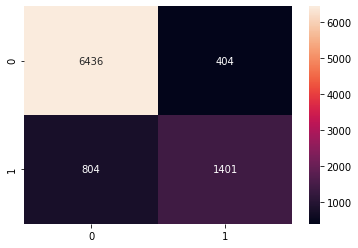

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

#pred = best_clf.predict(X_test)
sns.heatmap(confusion_matrix(y_test, best_predictions), annot = True, fmt = '')

#### Document results:

|     Metric     | Before Tuning     | After Tuning    |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |          0.8576   |      0.8664     |
| F-score        |          0.7246   |      0.7432     |


Results for optimised model:
- Final accuracy score on the testing data: 0.8664
- Final F-score on the testing data: 0.7432

The above scores are better than the unoptimised model

The optimised model has much better scores than the original naive predictor, which are as follows: Naive Predictor [Accuracy score: 0.2478, F-score: 0.2917]